In [4]:
# %%
"""
1) Load data, show column names and shape
2) Handle missing values
3) Visualizations: heatmap correlation w/ target, histograms, boxplots
4) Normalize data
5) Train classifiers: kNN, DecisionTree, SVM, RandomForest, AdaBoost
- tune k for kNN
- tune C and gamma for SVM with GridSearch
- show classification_report and confusion_matrix for best of each class
"""

'\n1) Load data, show column names and shape\n2) Handle missing values\n3) Visualizations: heatmap correlation w/ target, histograms, boxplots\n4) Normalize data\n5) Train classifiers: kNN, DecisionTree, SVM, RandomForest, AdaBoost\n- tune k for kNN\n- tune C and gamma for SVM with GridSearch\n- show classification_report and confusion_matrix for best of each class\n'

In [5]:
# %%
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [6]:
# For reproducibility
RANDOM_STATE = 42

In [7]:
# %%
# --- 1) Load data ---
# Using sklearn's breast cancer dataset as example; replace with your CSV if needed.
df = pd.read_csv("earthquake_data_tsunami.csv")
print(df.columns)

Index(['magnitude', 'cdi', 'mmi', 'sig', 'nst', 'dmin', 'gap', 'depth',
       'latitude', 'longitude', 'Year', 'Month', 'tsunami'],
      dtype='object')


In [8]:
X = df.drop('magnitude', axis=1)
y = df['magnitude']

print("Columns:")
print(list(X.columns))
print('\nShape: X:', X.shape, 'y:', y.shape)

Columns:
['cdi', 'mmi', 'sig', 'nst', 'dmin', 'gap', 'depth', 'latitude', 'longitude', 'Year', 'Month', 'tsunami']

Shape: X: (782, 12) y: (782,)


In [9]:
# %%
# --- 2) Handle missing values ---
print('\nMissing values per column:')
print(X.isna().sum())

imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)


Missing values per column:
cdi          0
mmi          0
sig          0
nst          0
dmin         0
gap          0
depth        0
latitude     0
longitude    0
Year         0
Month        0
tsunami      0
dtype: int64


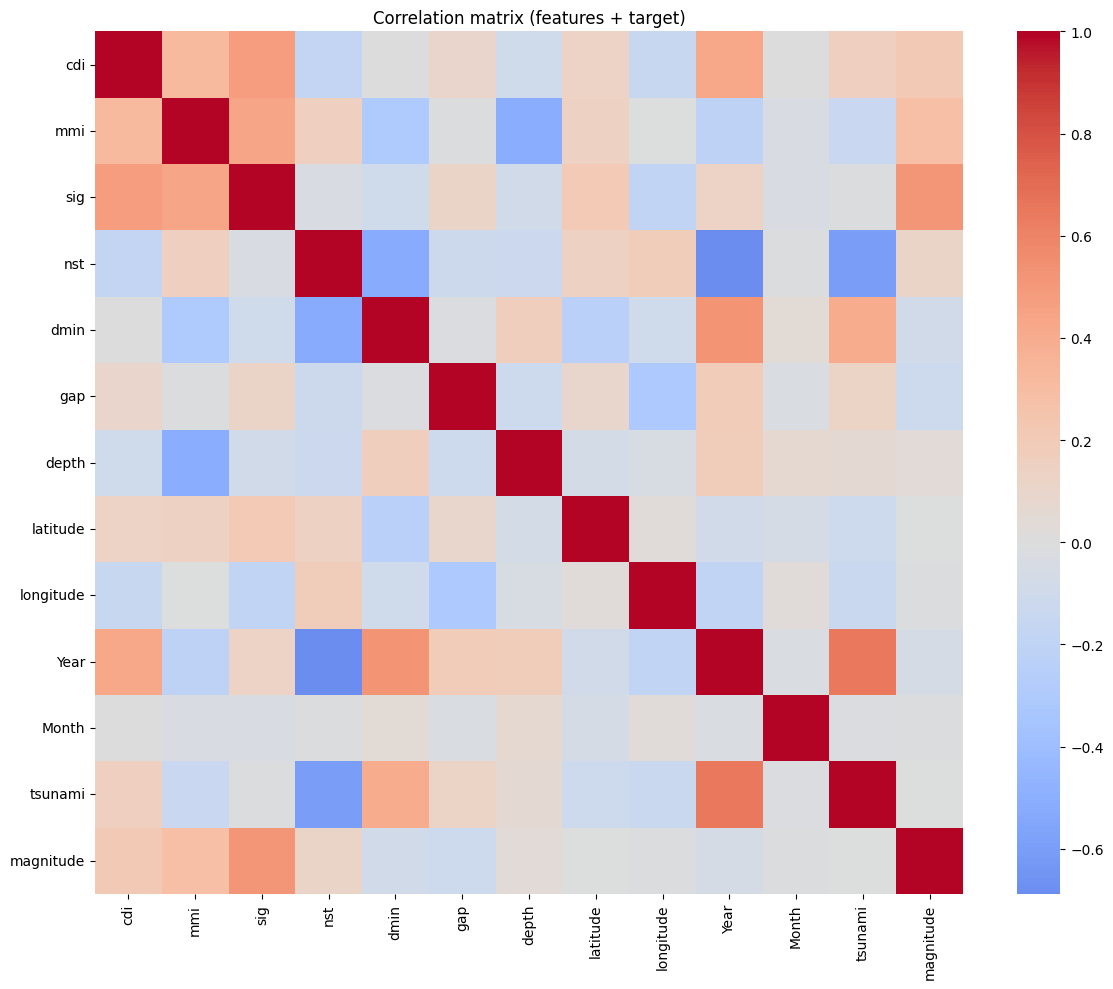


Top features by absolute correlation with target:
sig          0.515871
mmi          0.285552
cdi          0.209549
nst          0.113114
gap          0.110626
dmin         0.091403
Year         0.057083
depth        0.030644
longitude    0.013911
Month        0.011926
Name: magnitude, dtype: float64


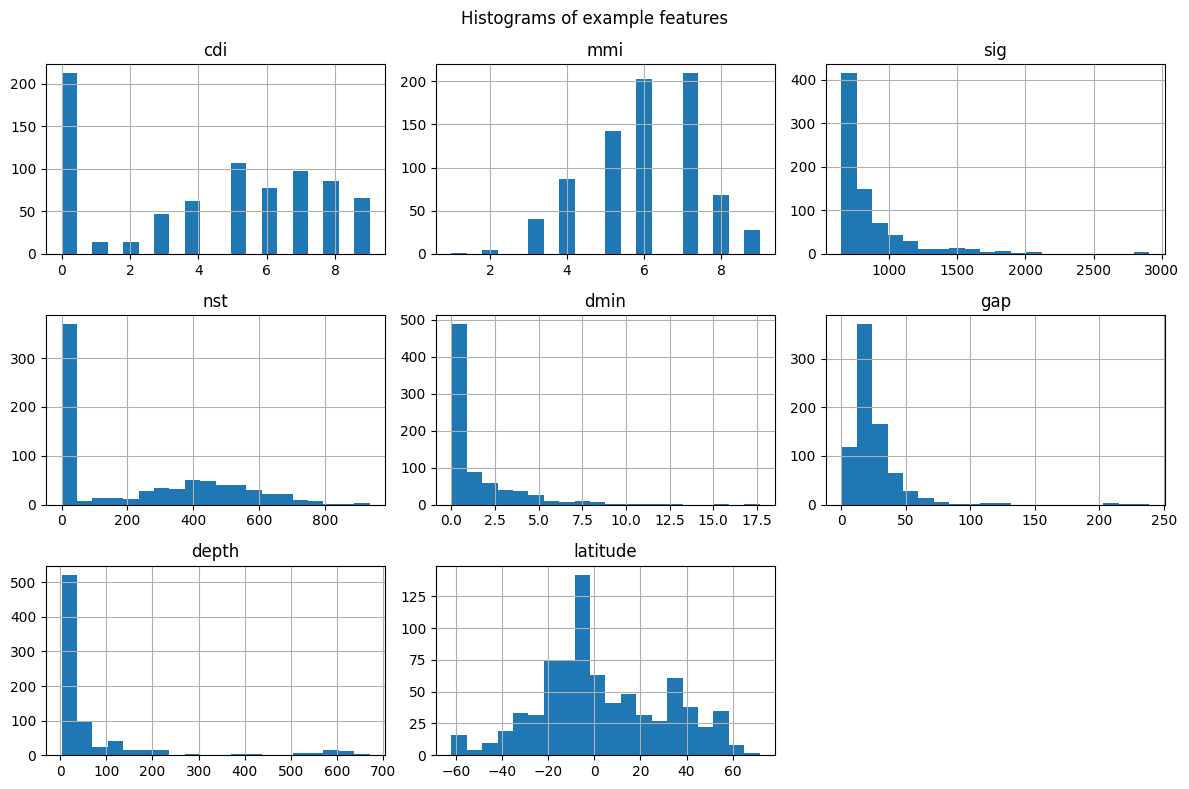

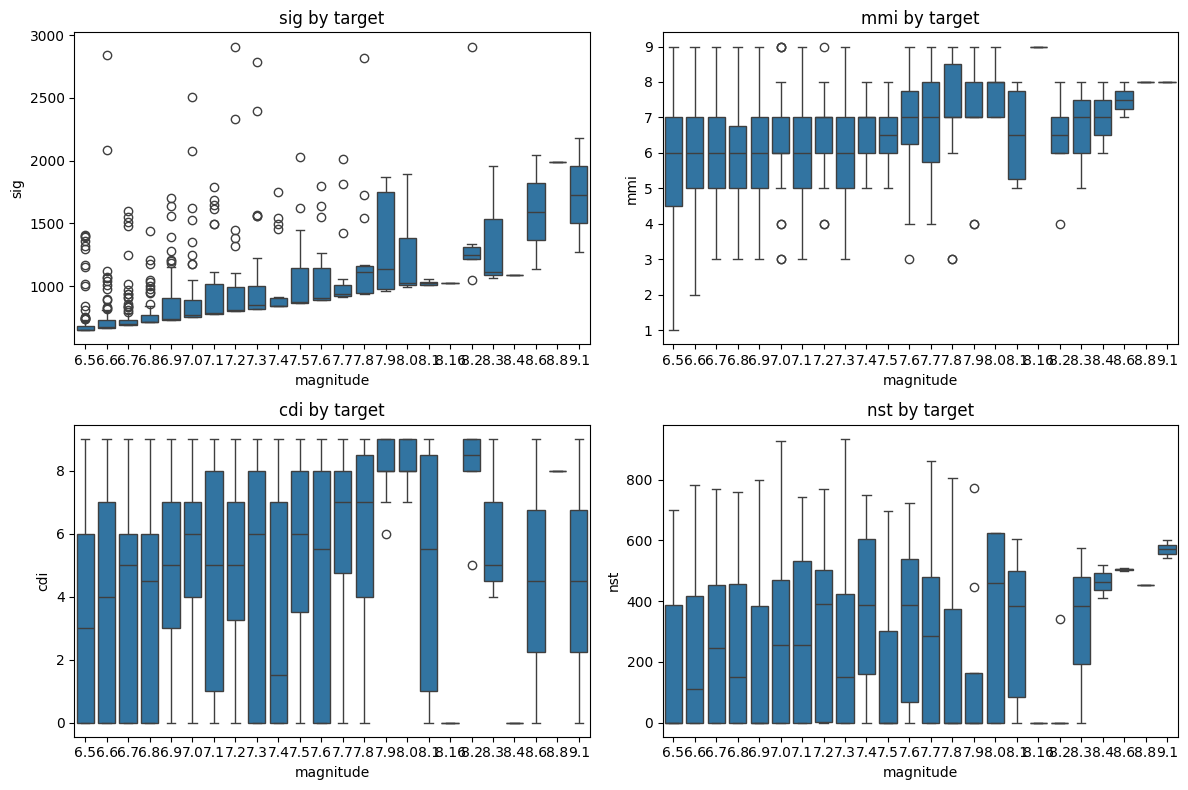

In [10]:
# %%
# --- 3) Visualizations ---
# Correlation heatmap
plt.figure(figsize=(12, 10))
# concat X and target for correlation
corr_df = pd.concat([X_imputed, y], axis=1)
corr = corr_df.corr()
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Correlation matrix (features + target)')
plt.tight_layout()
plt.show()

# Top 10 features by absolute correlation with target
corr_with_target = corr['magnitude'].drop('magnitude').abs().sort_values(ascending=False)
print('\nTop features by absolute correlation with target:')
print(corr_with_target.head(10))

# Histograms
features_to_plot = X_imputed.columns[:8]
X_imputed[features_to_plot].hist(bins=20, figsize=(12, 8))
plt.suptitle('Histograms of example features')
plt.tight_layout()
plt.show()

# Boxplots of features vs target
top_feats = corr_with_target.head(4).index.tolist()
plt.figure(figsize=(12, 8))
for i, feat in enumerate(top_feats, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=y, y=X_imputed[feat])
    plt.title(f'{feat} by target')
plt.tight_layout()
plt.show()

In [11]:
# %%
# --- 4) Normalize data ---
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X_imputed.columns)

In [12]:
# %%
# --- Split data ---
y = y.astype(int)
class_counts = y.value_counts()
if (class_counts < 2).any():
    print("Увага: є класи з менше ніж 2 зразками. Stratify відключено.")
    stratify_param = None
else:
    stratify_param = y
    
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=stratify_param
)

print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (625, 12) Test shape: (157, 12)


In [13]:
# %%
# --- 5) Train classifiers and hyperparameter tuning ---
results = {}

# kNN
knn_param_grid = {'n_neighbors': list(range(1, 21, 2)), 'weights': ['uniform', 'distance']}
knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, knn_param_grid, cv=5, scoring='f1', n_jobs=-1)
knn_grid.fit(X_train, y_train)
results['kNN'] = knn_grid
print('kNN best params:', knn_grid.best_params_, 'best score:', knn_grid.best_score_)

# Decision Tree
dt_param_grid = {'max_depth': [None, 3, 5, 7, 9], 'min_samples_split':[2,5,10]}
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt_grid = GridSearchCV(dt, dt_param_grid, cv=5, scoring='f1', n_jobs=-1)
dt_grid.fit(X_train, y_train)
results['DecisionTree'] = dt_grid
print('DecisionTree best params:', dt_grid.best_params_, 'best score:', dt_grid.best_score_)

# SVM
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.001],
    'kernel': ['rbf']
}
svm = SVC(probability=False, random_state=RANDOM_STATE)
svm_grid = GridSearchCV(svm, svm_param_grid, cv=3, scoring='f1', n_jobs=-1)
svm_grid.fit(X_train, y_train)
results['SVM'] = svm_grid
print('SVM best params:', svm_grid.best_params_, 'best score:', svm_grid.best_score_)

# Random Forest
rf_param_grid = {'n_estimators':[50,100,200], 'max_depth':[None,5,10], 'min_samples_split':[2,5]}
rf = RandomForestClassifier(random_state=RANDOM_STATE)
rf_grid = GridSearchCV(rf, rf_param_grid, cv=5, scoring='f1', n_jobs=-1)
rf_grid.fit(X_train, y_train)
results['RandomForest'] = rf_grid
print('RandomForest best params:', rf_grid.best_params_, 'best score:', rf_grid.best_score_)

# AdaBoost (with DecisionTree base estimator)
adb_param_grid = {'n_estimators':[50,100,200], 'learning_rate':[0.5,1.0,1.5]}
adb = AdaBoostClassifier(random_state=RANDOM_STATE)
adb_grid = GridSearchCV(adb, adb_param_grid, cv=5, scoring='f1', n_jobs=-1)
adb_grid.fit(X_train, y_train)
results['AdaBoost'] = adb_grid
print('AdaBoost best params:', adb_grid.best_params_, 'best score:', adb_grid.best_score_)

c:\Users\misha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\misha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(
c:\Users\misha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\misha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\misha\AppData\Lo

kNN best params: {'n_neighbors': 1, 'weights': 'uniform'} best score: nan
DecisionTree best params: {'max_depth': None, 'min_samples_split': 2} best score: nan
SVM best params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'} best score: nan


c:\Users\misha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
c:\Users\misha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


RandomForest best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50} best score: nan
AdaBoost best params: {'learning_rate': 0.5, 'n_estimators': 50} best score: nan


c:\Users\misha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan]
  warnings.warn(



Evaluating kNN on test set

Classification report for kNN
              precision    recall  f1-score   support

           6     0.7524    0.7900    0.7707       100
           7     0.5200    0.5098    0.5149        51
           8     0.5000    0.2000    0.2857         5
           9     0.0000    0.0000    0.0000         1

    accuracy                         0.6752       157
   macro avg     0.4431    0.3750    0.3928       157
weighted avg     0.6641    0.6752    0.6673       157



c:\Users\misha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\misha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\misha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

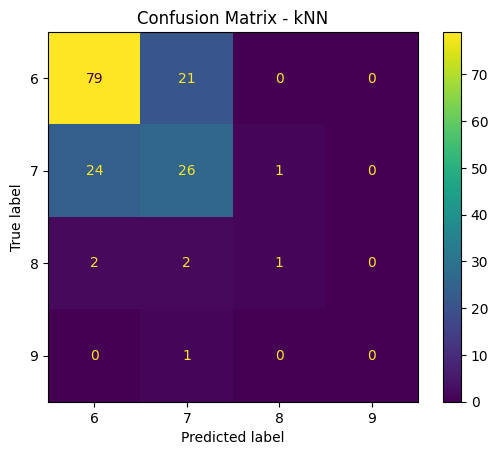


Evaluating DecisionTree on test set

Classification report for DecisionTree
              precision    recall  f1-score   support

           6     0.8922    0.9100    0.9010       100
           7     0.7500    0.7059    0.7273        51
           8     0.2857    0.4000    0.3333         5
           9     0.0000    0.0000    0.0000         1

    accuracy                         0.8217       157
   macro avg     0.4820    0.5040    0.4904       157
weighted avg     0.8210    0.8217    0.8207       157



c:\Users\misha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\misha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\misha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

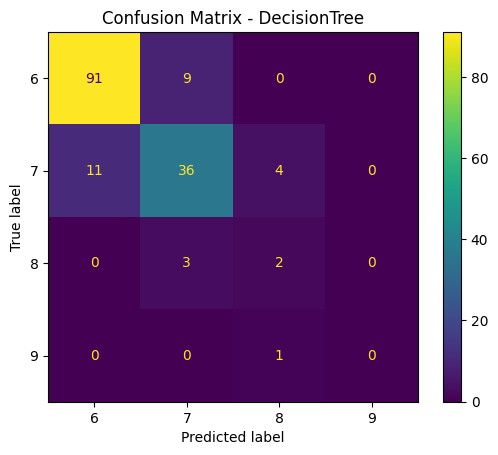


Evaluating SVM on test set

Classification report for SVM
              precision    recall  f1-score   support

           6     0.6494    1.0000    0.7874       100
           7     0.3333    0.0196    0.0370        51
           8     0.0000    0.0000    0.0000         5
           9     0.0000    0.0000    0.0000         1

    accuracy                         0.6433       157
   macro avg     0.2457    0.2549    0.2061       157
weighted avg     0.5219    0.6433    0.5136       157



c:\Users\misha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\misha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\misha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

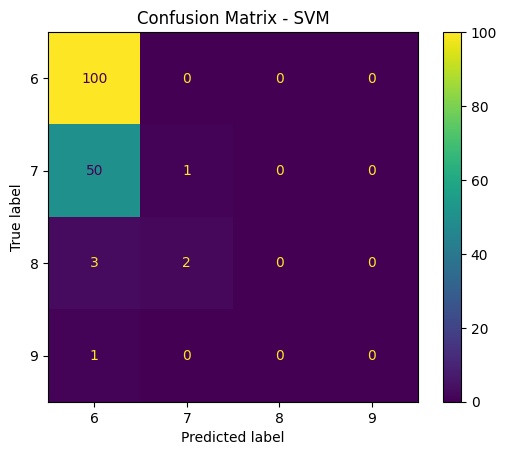


Evaluating RandomForest on test set

Classification report for RandomForest
              precision    recall  f1-score   support

           6     0.9588    0.9300    0.9442       100
           7     0.7833    0.9216    0.8468        51
           8     0.0000    0.0000    0.0000         5
           9     0.0000    0.0000    0.0000         1

    accuracy                         0.8917       157
   macro avg     0.4355    0.4629    0.4478       157
weighted avg     0.8651    0.8917    0.8765       157



c:\Users\misha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\misha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\misha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

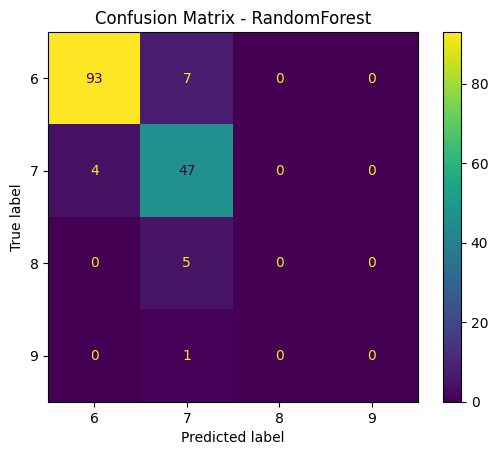


Evaluating AdaBoost on test set

Classification report for AdaBoost


c:\Users\misha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\misha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\misha\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

              precision    recall  f1-score   support

           6     1.0000    0.8200    0.9011       100
           7     0.6712    0.9608    0.7903        51
           8     0.0000    0.0000    0.0000         5
           9     0.0000    0.0000    0.0000         1

    accuracy                         0.8344       157
   macro avg     0.4178    0.4452    0.4229       157
weighted avg     0.8550    0.8344    0.8307       157



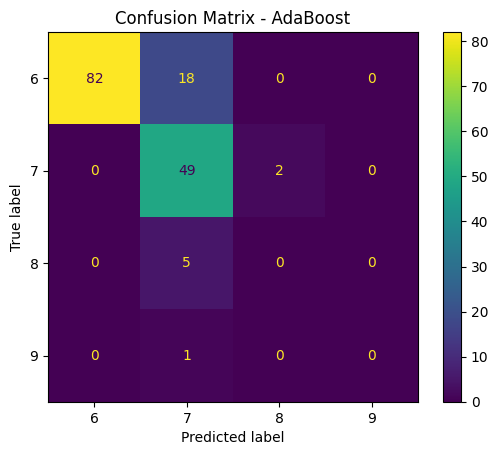

kNN test F1: 0.6673
DecisionTree test F1: 0.8207
SVM test F1: 0.5136
RandomForest test F1: 0.8765
AdaBoost test F1: 0.8307

Best model on test set: RandomForest with F1 = 0.8764677251210926


In [14]:
# %%
# --- 6) Evaluate best model from each classifier family on test set ---

best_models = {name: grid.best_estimator_ for name, grid in results.items()}

for name, model in best_models.items():
    print('\n' + '='*40)
    print(f'Evaluating {name} on test set')
    y_pred = model.predict(X_test)
    print('\nClassification report for', name)
    print(classification_report(y_test, y_pred, digits=4))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
    disp.plot()
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

# Choose overall best model by F1-score on test set
from sklearn.metrics import f1_score

best_name = None
best_f1 = -1

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'{name} test F1: {f1:.4f}')
    if f1 > best_f1:
        best_f1 = f1
        best_name = name

print('\nBest model on test set:', best_name, 'with F1 =', best_f1)

In [15]:
# %%
# End of notebook
print('Done. Replace dataset loading block with your CSV and re-run.')


Done. Replace dataset loading block with your CSV and re-run.
